In [1]:
from catboost import CatBoostClassifier, CatBoostRegressor
import datetime
import gc
import joblib
from lightgbm import LGBMClassifier, LGBMRegressor
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import metrics

from tqdm import tqdm

from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree

pd.set_option("display.max_rows", 100000)
pd.set_option("display.max_columns", 100000)

sns.set()

%matplotlib inline

As an example, data from https://www.kaggle.com/datasets/chitrakumari25/smart-agricultural-production-optimizing-engine is used.

The example is related to a multiclass classification task, but one can use an input data file related to binary classification or regression tasks.

# Input
In the following cell insert:
- the input dataset file
- the target column

In [2]:
dataset = '../data/Crop_recommendation.csv'
target = 'label'

In [3]:
df = pd.read_csv(dataset)

# # Only for using LGBMRegressor()
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# # but if using one hot encoding or if this creates duplicate 
# # columns things must be refined. See the One Hot Encoding section for a solution.

# # For experimenting with a smaller dataset
# df = df.groupby(target, group_keys=False).apply(lambda x: x.sample(frac=0.15))
# df = df.sample(1000, random_state=42)

In [4]:
num_features = df.select_dtypes(include="number").columns.to_list()

# Automatically detect task

In [5]:
TASKS = ["binary classification", "multiclass classification", "regression"]

def infer_task():
    target_type = df[target].dtype
    target_nunique = df[target].nunique()
    if target_type == bool or target_nunique == 2:
        return TASKS[0]
    elif target_type == 'float64':
        return TASKS[2]
    elif target_type == 'int64':
        print(
            f"Set task as {TASKS[2]} but double check it.\n"
            + f"There are {target_nunique} different values in the target."
        )
        return TASKS[2]
    else:
        print(
            f"Set task as {TASKS
            [1]} but double check it.\n"
            + f"There are {target_nunique} different values in the target."
        )
        return TASKS[1]


task = infer_task()
task

Set task as multiclass classification but double check it.
There are 22 different values in the target.


'multiclass classification'

In [6]:
class_flag = (task != TASKS[2]) 
binary_flag = (task == TASKS[0])

# DataFrame Analysis

In [7]:
display(df.head().style)
# df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [8]:
print(df.shape)
# df.shape

(2200, 8)


In [9]:
print(df.info())
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None


In [10]:
display(df.describe().style)
# df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [11]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [12]:
# print(pd.value_counts(df.dtypes))
# pd.value_counts(df.dtypes)    # Deprecated

# pd.Series(df.dtypes).value_counts()
print(pd.Series(df.dtypes).value_counts())

float64    4
int64      3
object     1
Name: count, dtype: int64


# Duplicates

In [13]:
print(df.duplicated().sum())
# df.duplicated().sum()

0


# Null values

In [14]:
print(df.isnull().values.any())
# df.isnull().values.any()

False


# Missing values

Text(0, 0.5, 'Sample Number')

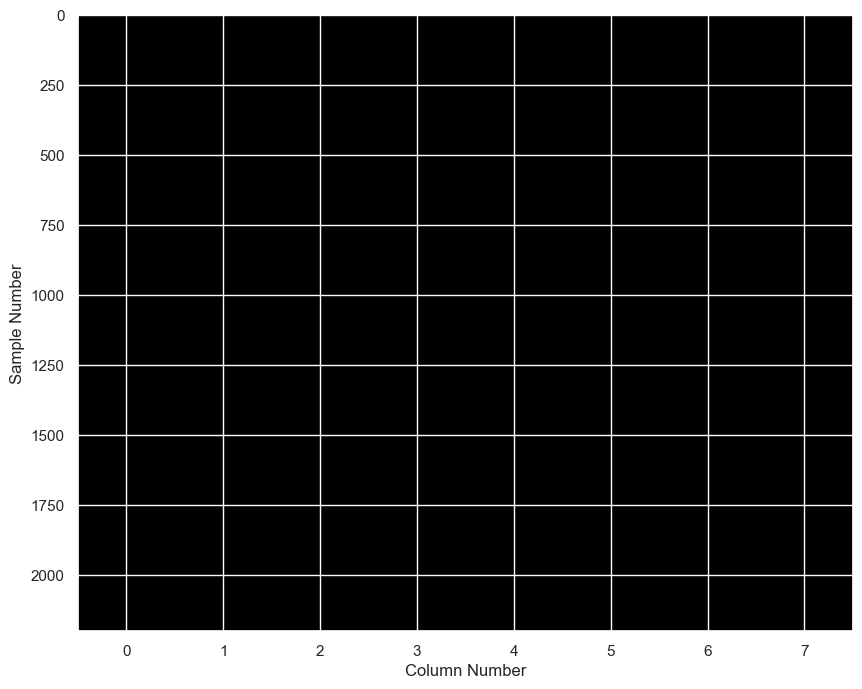

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray") 
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

<Axes: >

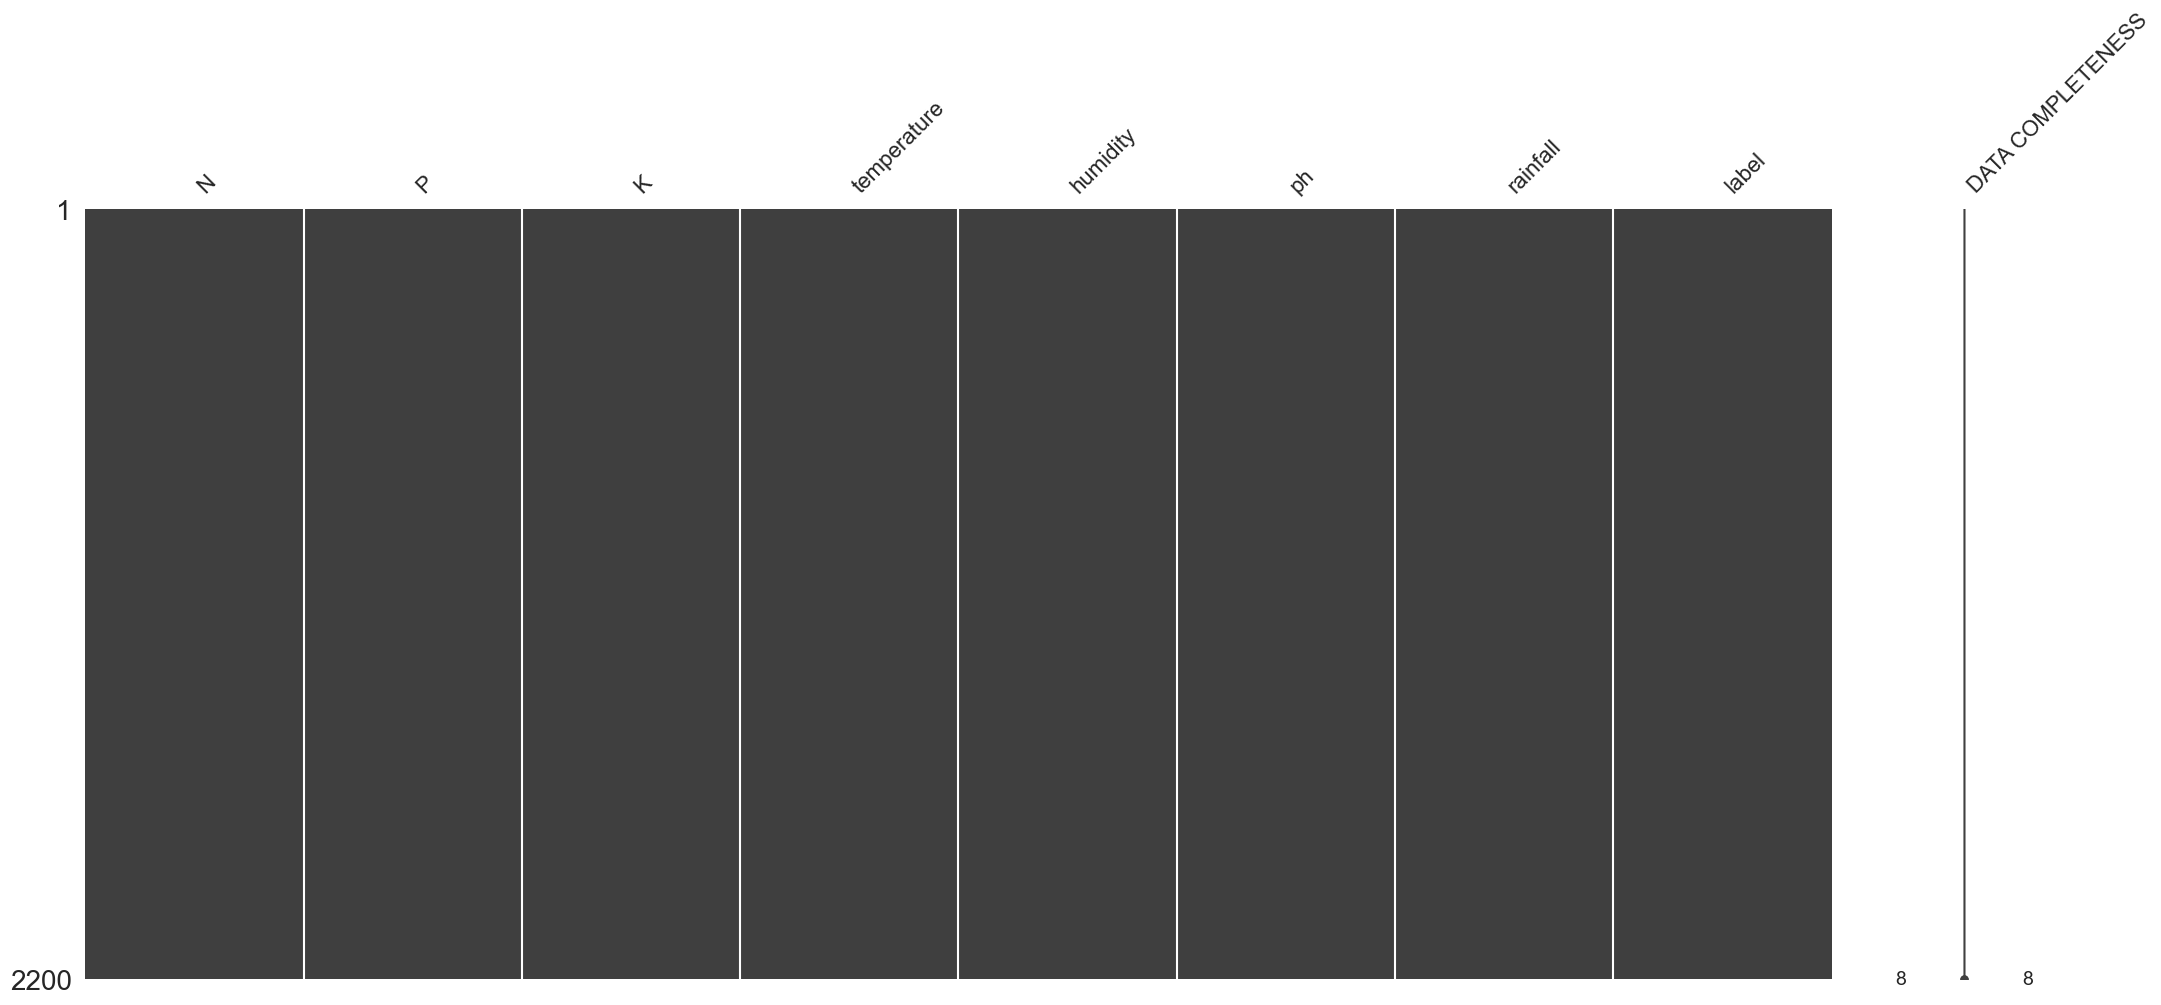

In [16]:
msno.matrix(df, labels=True, sort="descending")

<Axes: title={'center': 'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

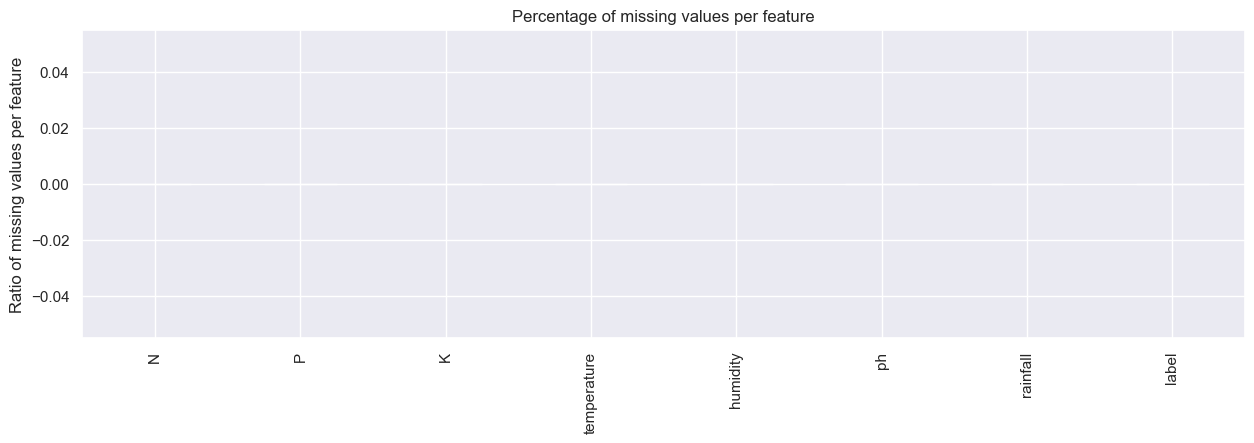

In [17]:
df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 4),
title="Percentage of missing values per feature", ylabel="Ratio of missing values per feature")

# Categorical variables

In [18]:
# df.select_dtypes(exclude=["number", "datetime"]).head()

# df.select_dtypes(exclude="number").head()
display(df.select_dtypes(exclude="number").head().style)

,label
0,rice
1,rice
2,rice
3,rice
4,rice


In [19]:
cat_col = df.select_dtypes(exclude=["number","datetime"]).columns.to_list()
cat_col

['label']

  0%|                                                                                                                                      | 0/1 [00:00<?, ?it/s]

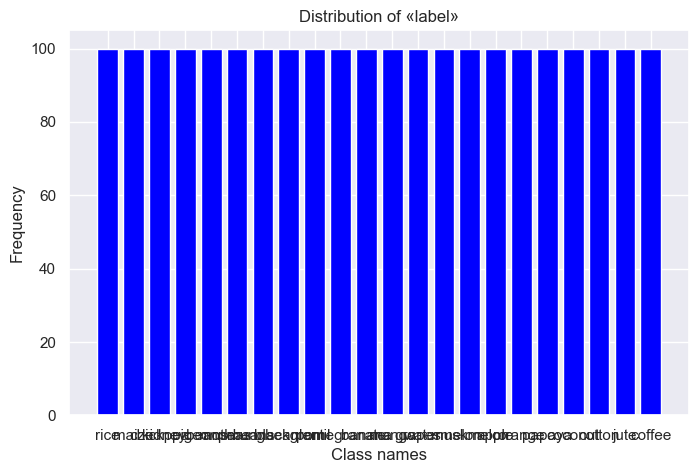

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


In [20]:
for elem in tqdm(cat_col):
   names = df[elem].value_counts().keys()
   counts = df[elem].value_counts().values
   plt.subplots(figsize=(8, 5))
   plt.bar(names, counts, color="blue")
   plt.xlabel("Class names")
   plt.ylabel("Frequency")
   plt.title(f"Distribution of «{elem}»")
   plt.show()


# Target (for classification problems)

In [21]:
if class_flag:
    # print(df.groupby(target).size())
    print(df[target].value_counts())

label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


#### Further work is required in dealing with an unbalanced dataset: for instance, apply undersampling or oversampling, create synthetic data, etc.

# Unique values for numerical features

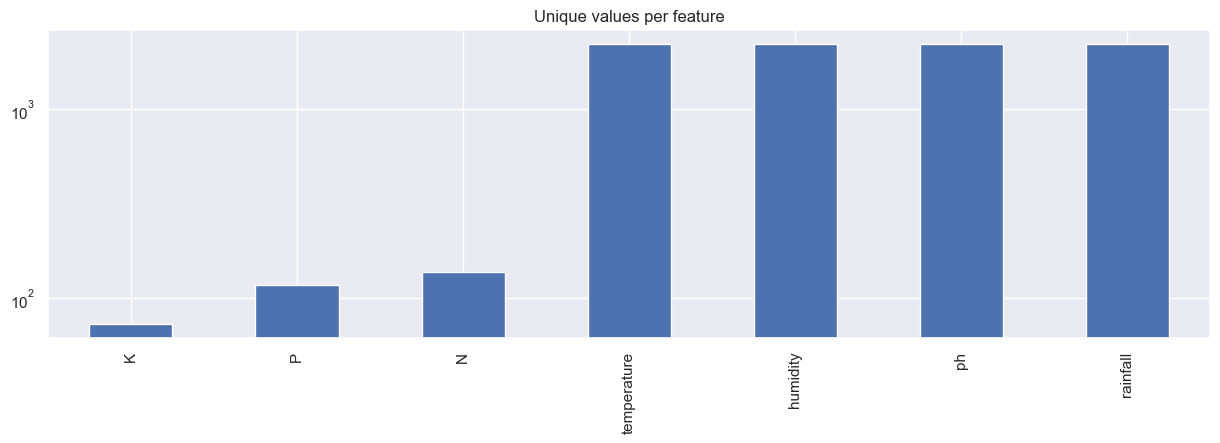

In [22]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature")
plt.show()

# Plots for numerical features

  0%|                                                                                                                                      | 0/7 [00:00<?, ?it/s]

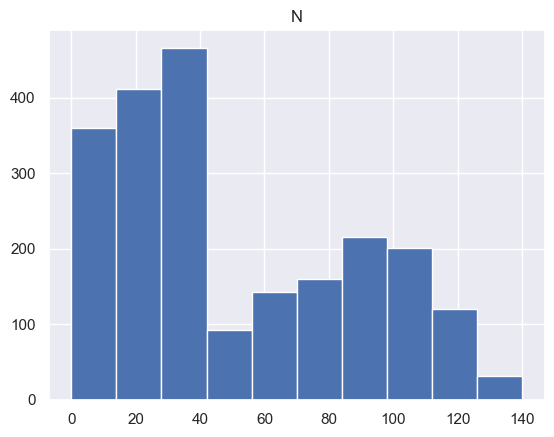

 14%|██████████████████                                                                                                            | 1/7 [00:00<00:00,  6.68it/s]

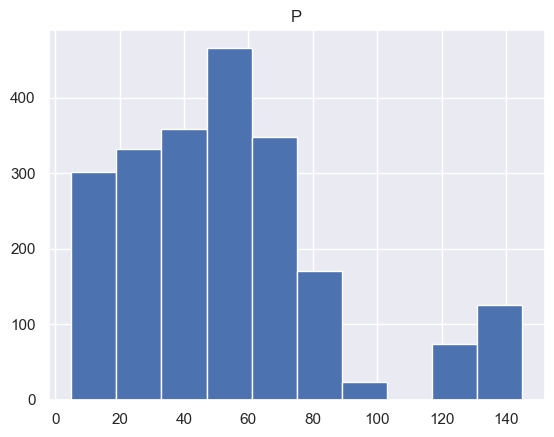

 29%|████████████████████████████████████                                                                                          | 2/7 [00:00<00:00,  7.42it/s]

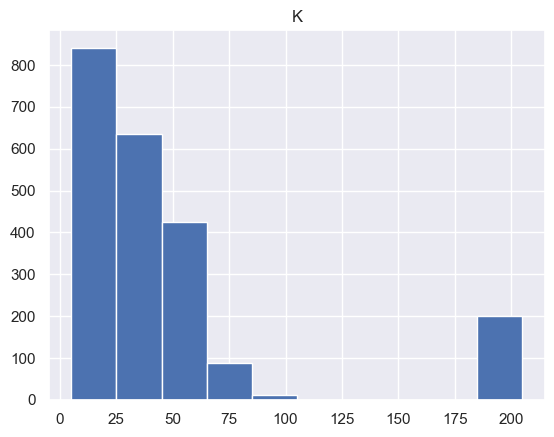

 43%|██████████████████████████████████████████████████████                                                                        | 3/7 [00:00<00:00,  7.68it/s]

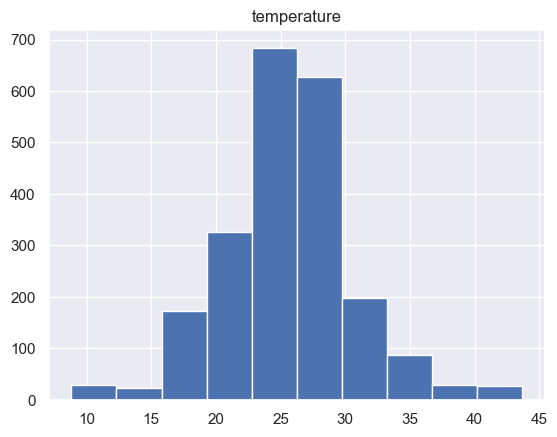

 57%|████████████████████████████████████████████████████████████████████████                                                      | 4/7 [00:00<00:00,  7.94it/s]

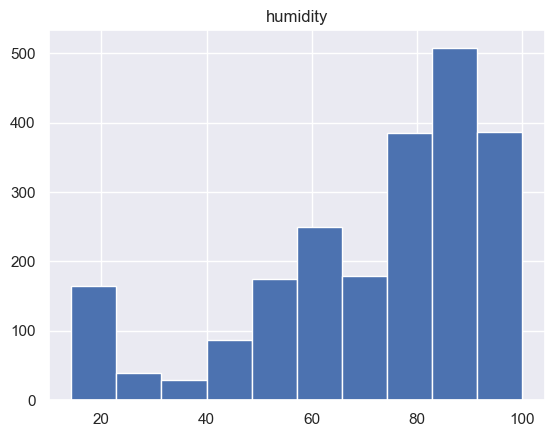

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 5/7 [00:00<00:00,  8.42it/s]

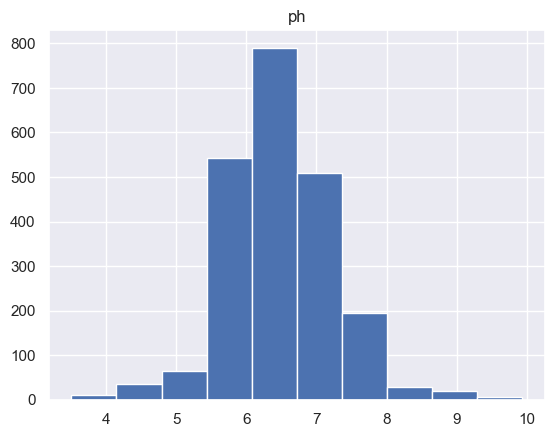

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6/7 [00:00<00:00,  8.37it/s]

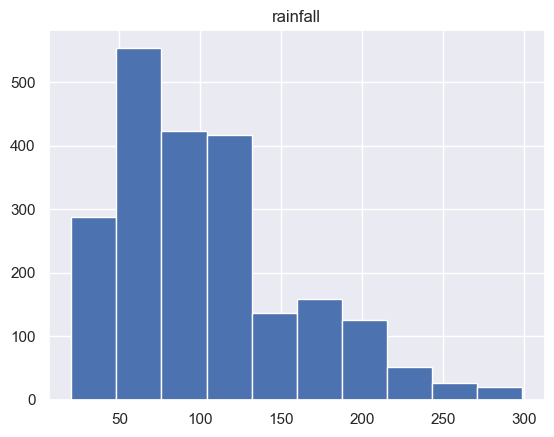

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.17it/s]


In [23]:
for elem in tqdm(num_features):
    df.hist(column=elem)
    plt.show()

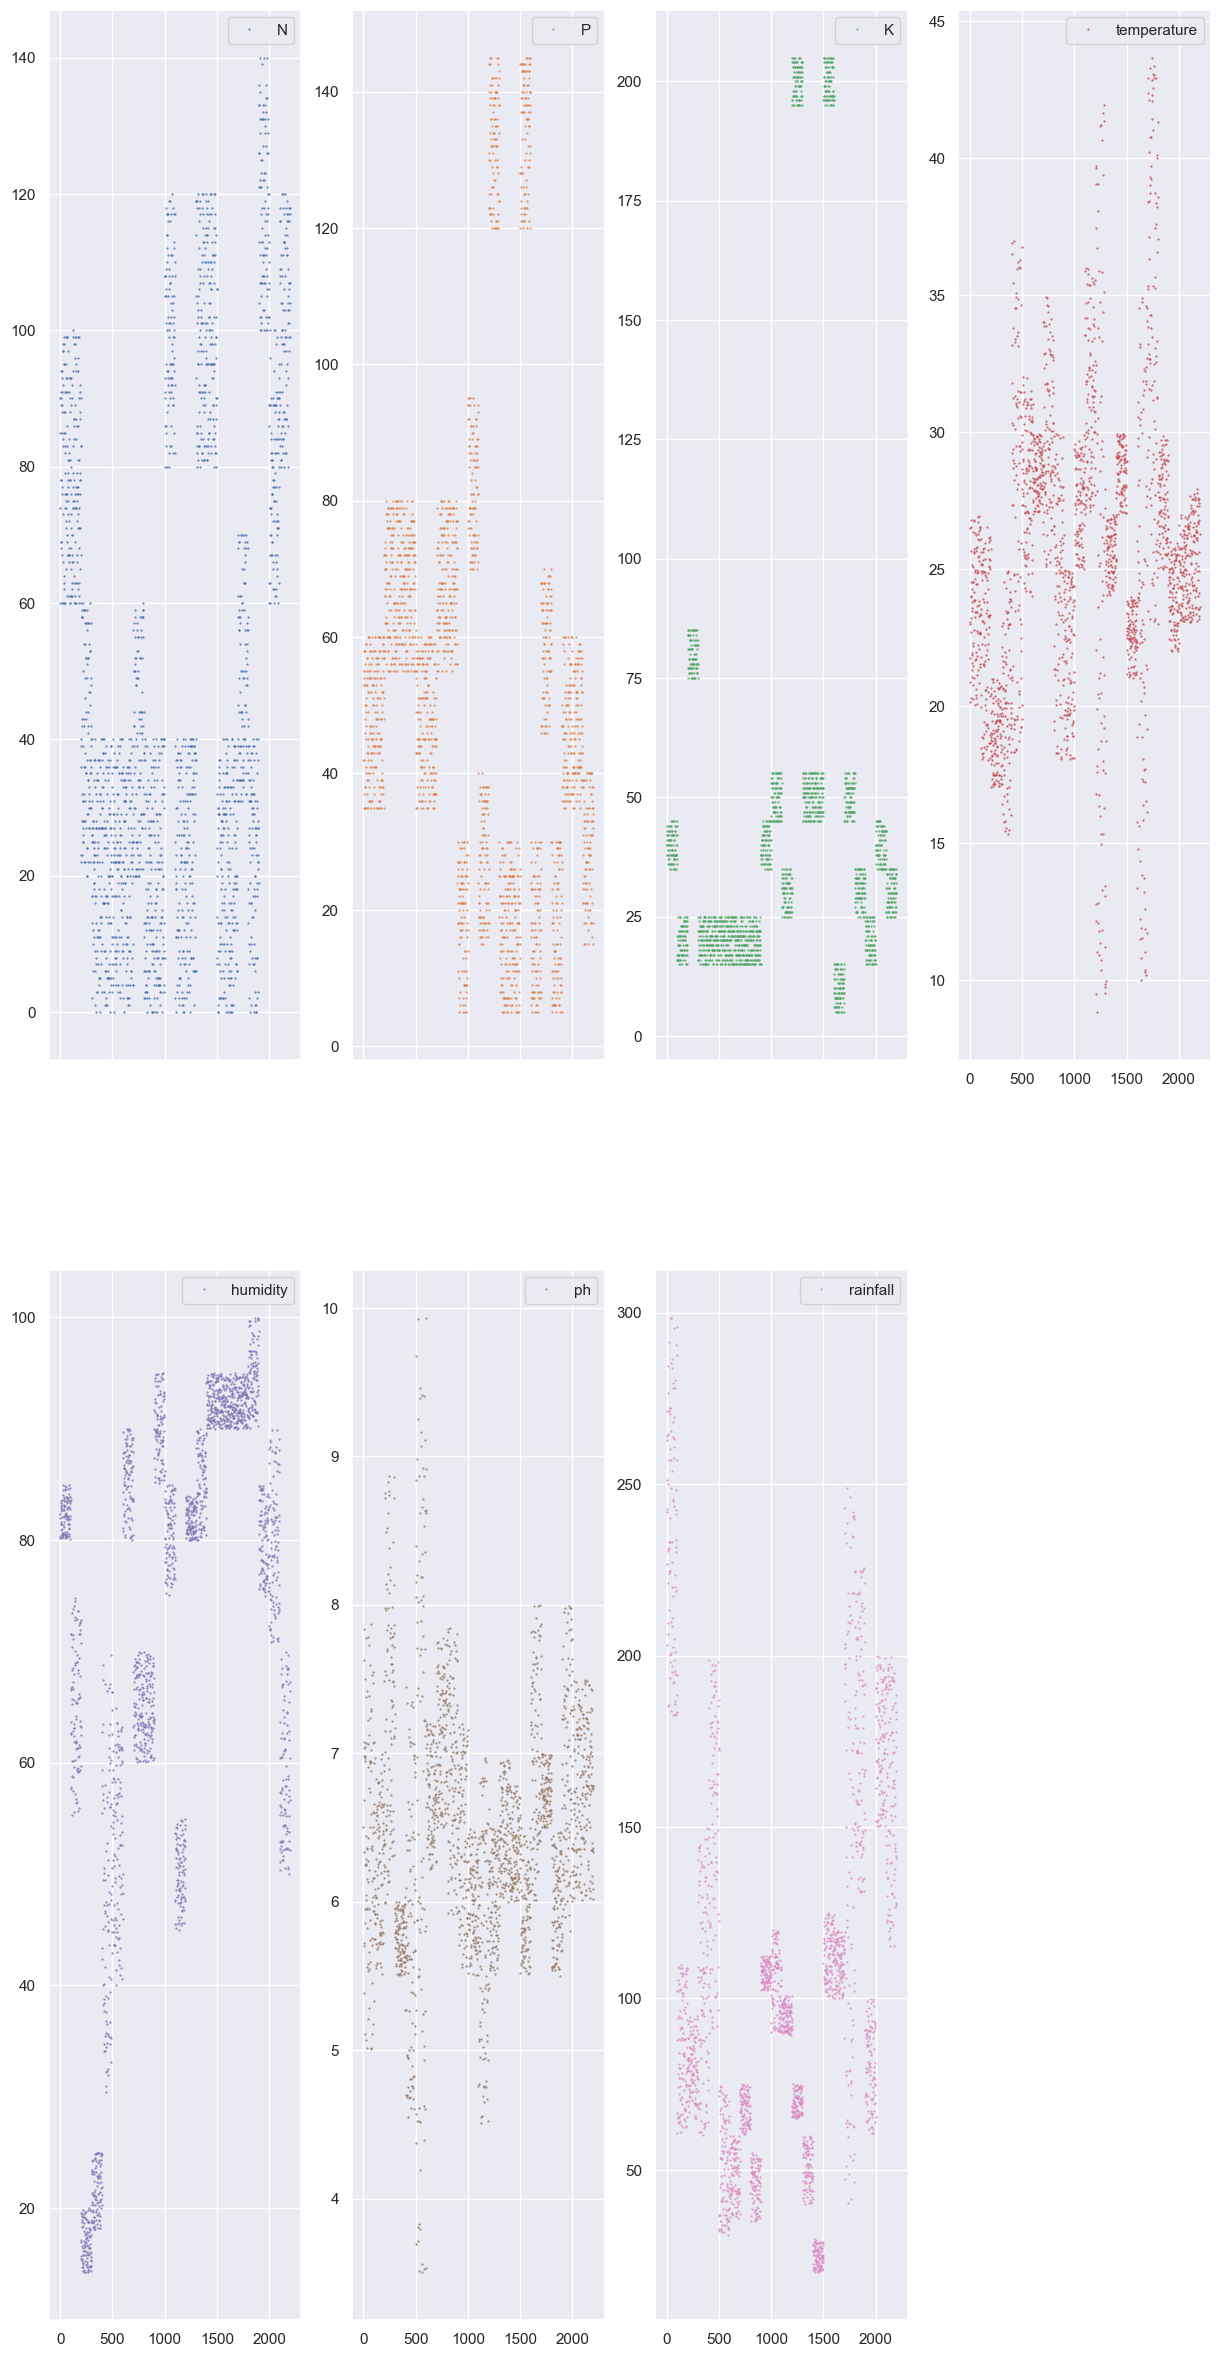

In [24]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4), figsize=(15, 30), markersize=1)
# plt.tight_layout()
plt.show()

# Entries frequency

humidity       0.002273
ph             0.000455
label          0.000455
N              0.000000
temperature    0.000000
dtype: float64

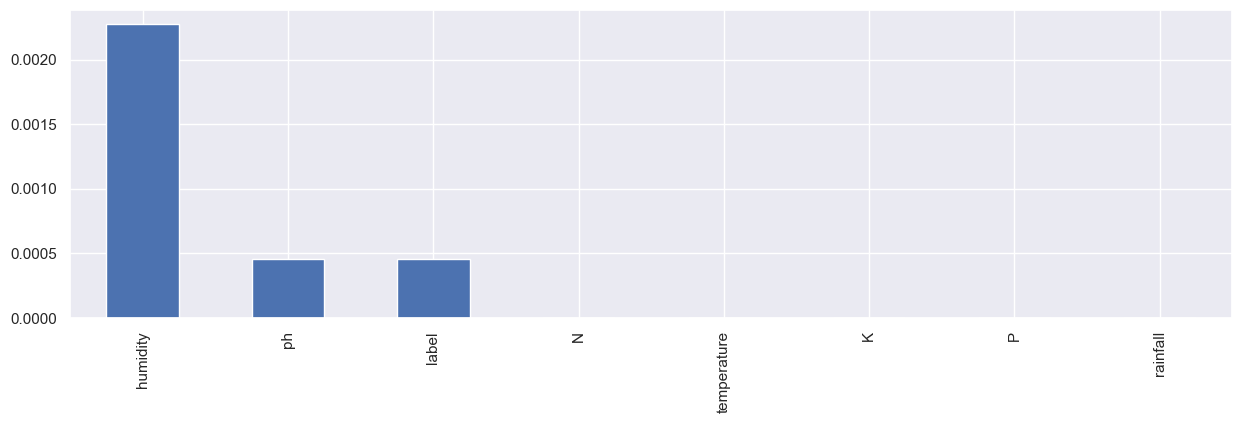

In [25]:
most_frequent_entry = df.mode()
df_freq = df.eq(most_frequent_entry.values, axis=1)
df_freq = df_freq.mean().sort_values(ascending=False)
display(df_freq.head())
df_freq.plot.bar(figsize=(15, 4))
plt.show()

# Relations between variables

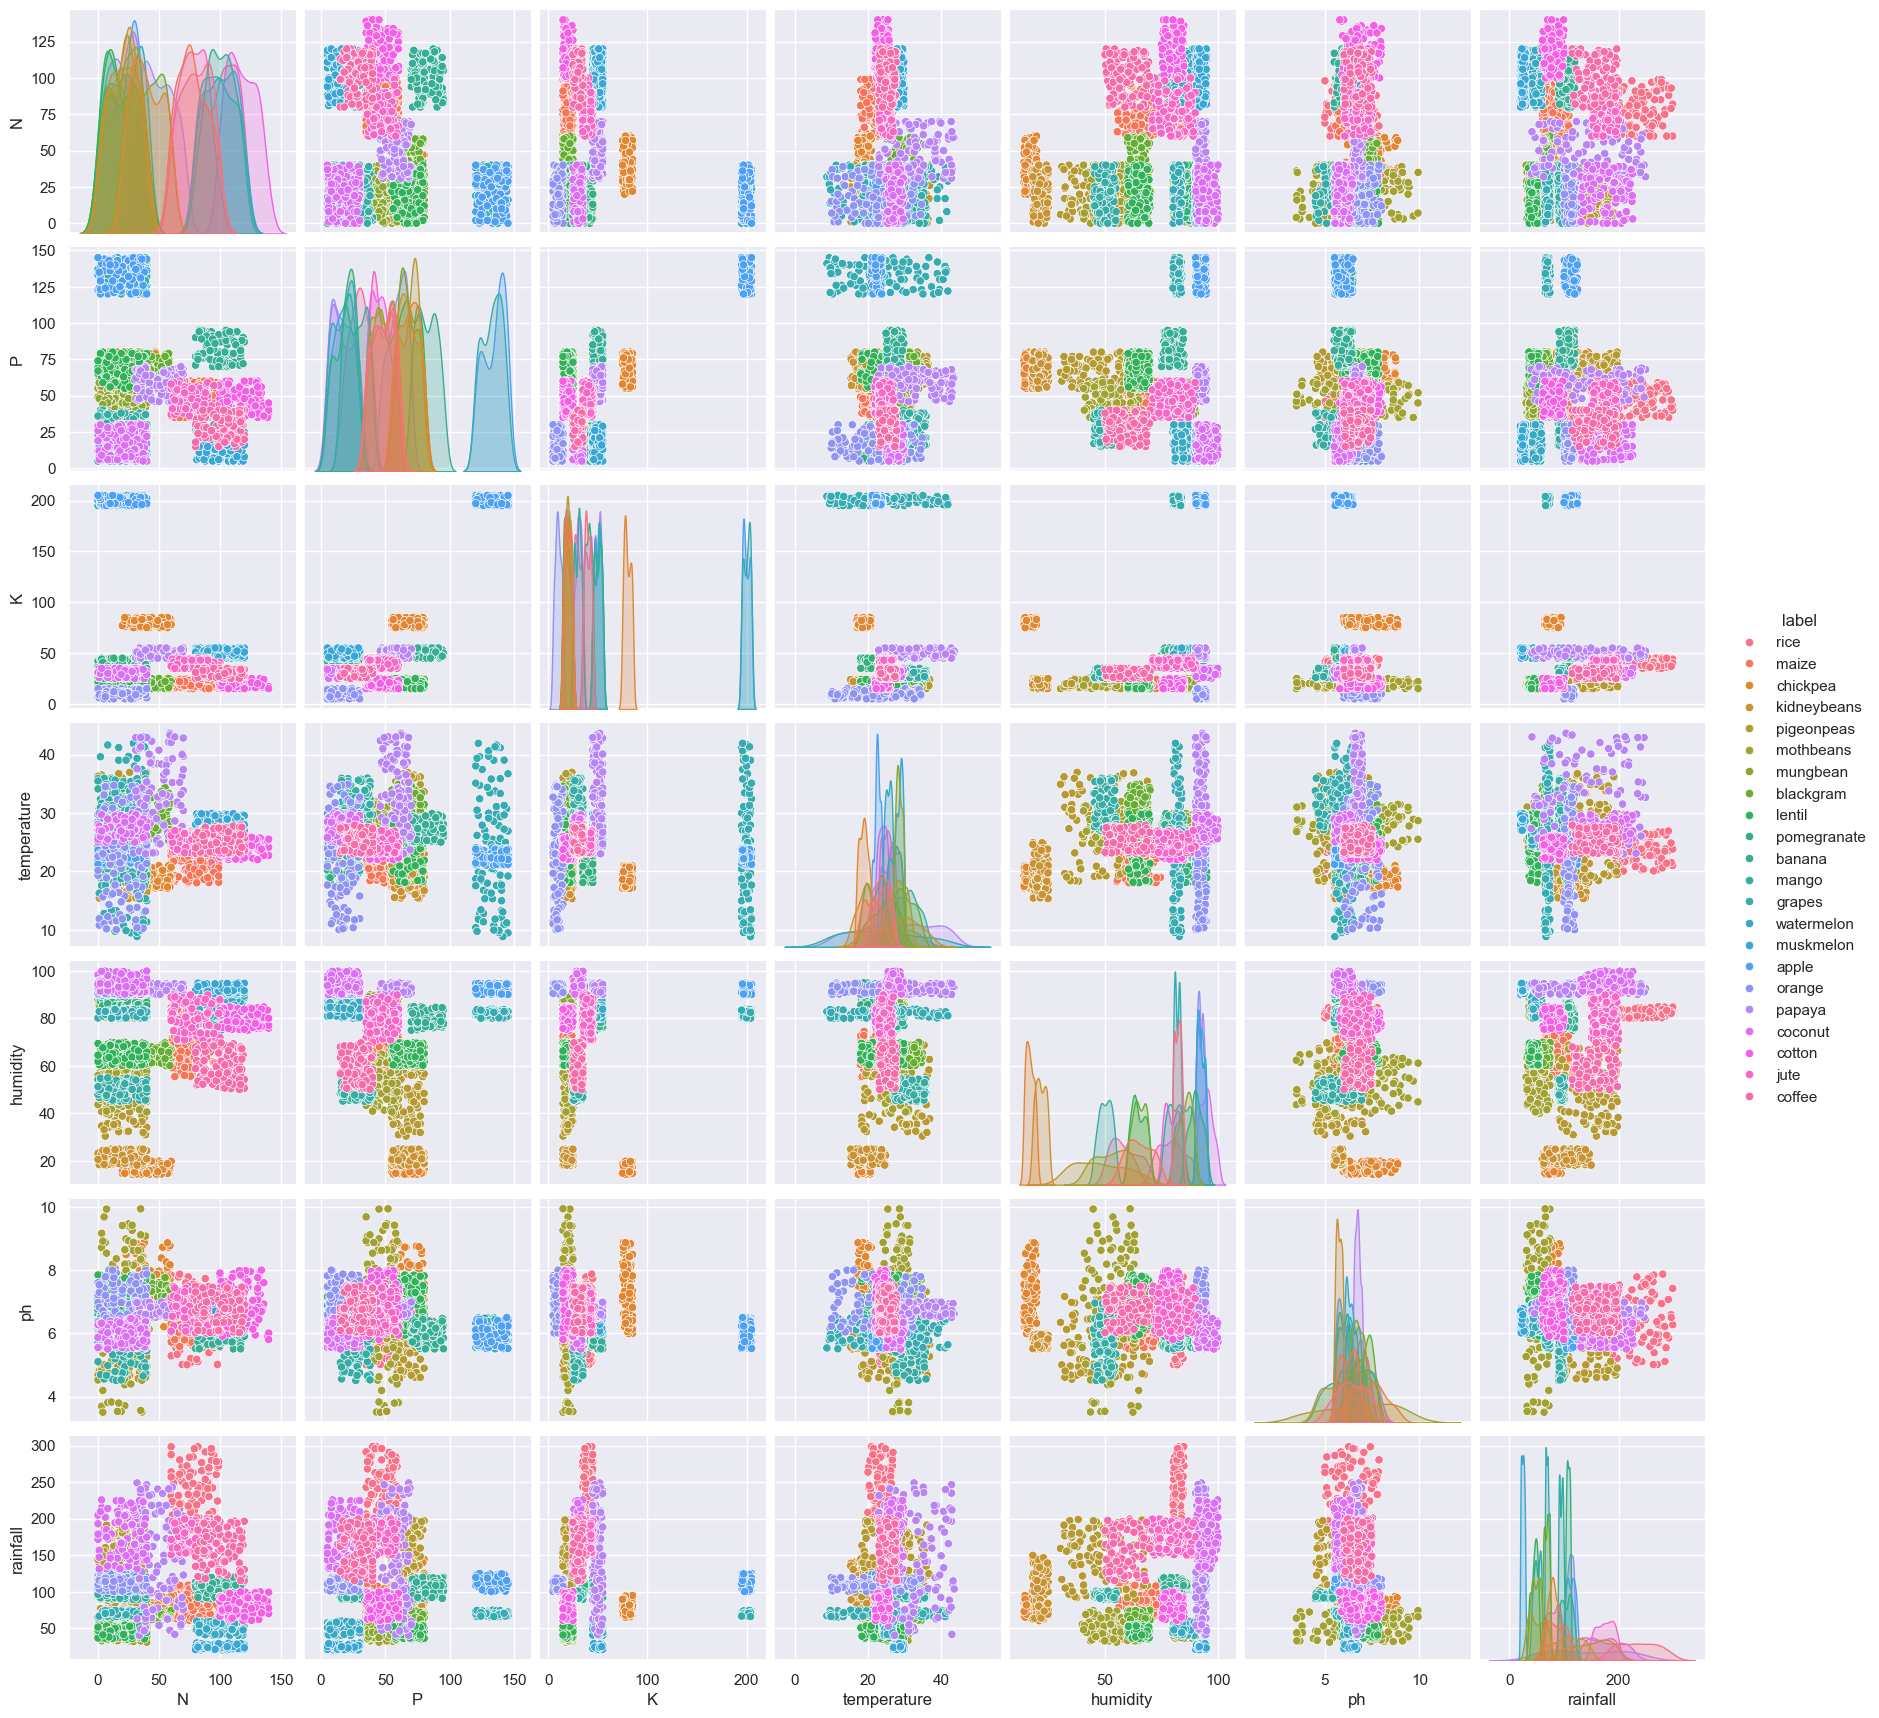

In [26]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(df)
# plt.show()

# For both classification and regression problems
sns.pairplot(df, hue=target)
plt.show()

In [27]:
pairwise_corr = df[num_features].corr()
display(pairwise_corr.style)

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


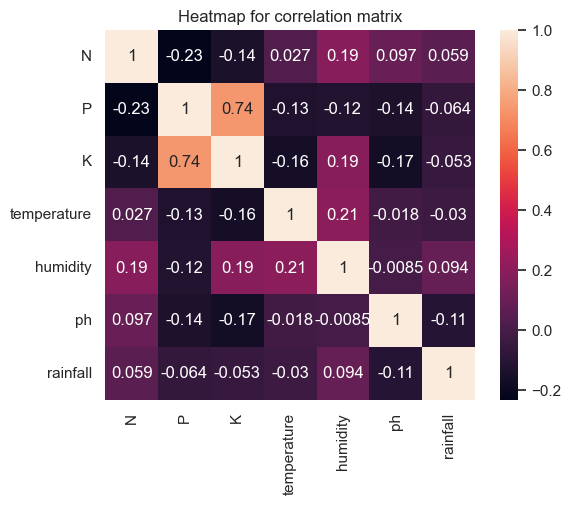

In [28]:
sns.heatmap(pairwise_corr, annot = True, square = True)
plt.title('Heatmap for correlation matrix')
plt.show()

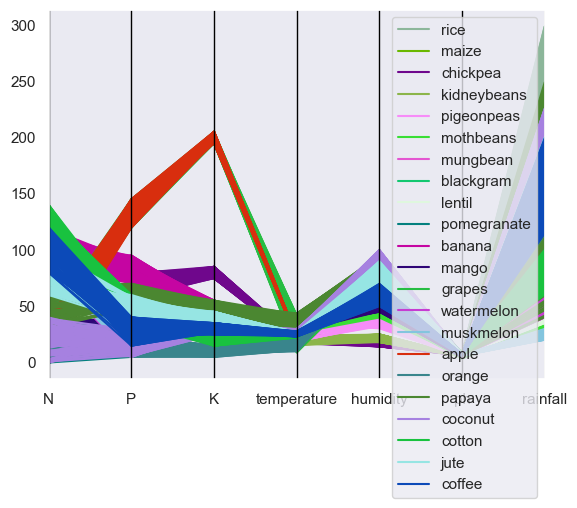

In [29]:
if class_flag:
    ll= num_features[:]
    if target not in num_features:
        ll.append(target)
    pd.plotting.parallel_coordinates(df[ll], target)
    plt.show()

  0%|                                                                                                                                      | 0/7 [00:00<?, ?it/s]

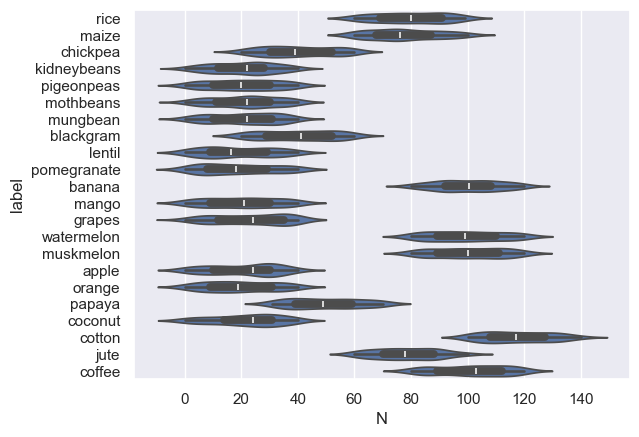

 14%|██████████████████                                                                                                            | 1/7 [00:00<00:02,  2.91it/s]

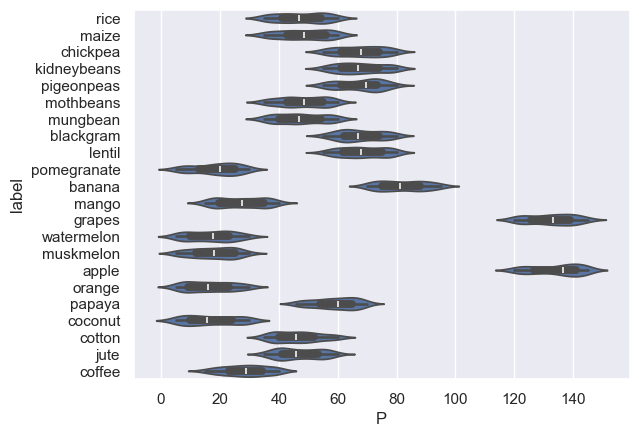

 29%|████████████████████████████████████                                                                                          | 2/7 [00:00<00:01,  3.15it/s]

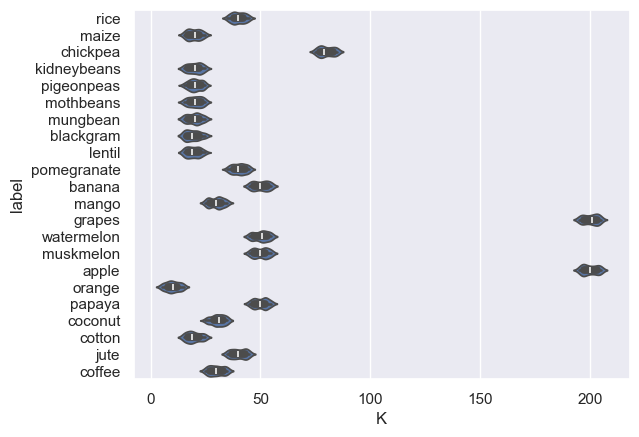

 43%|██████████████████████████████████████████████████████                                                                        | 3/7 [00:00<00:01,  3.29it/s]

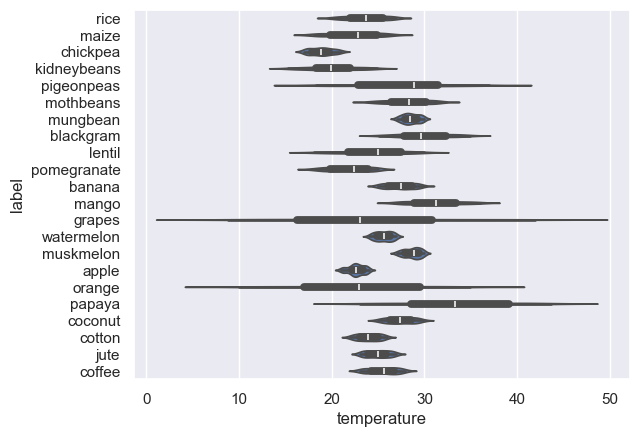

 57%|████████████████████████████████████████████████████████████████████████                                                      | 4/7 [00:01<00:00,  3.37it/s]

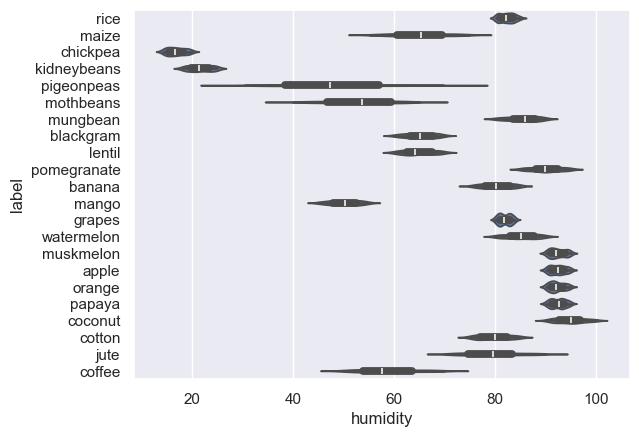

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 5/7 [00:01<00:00,  3.36it/s]

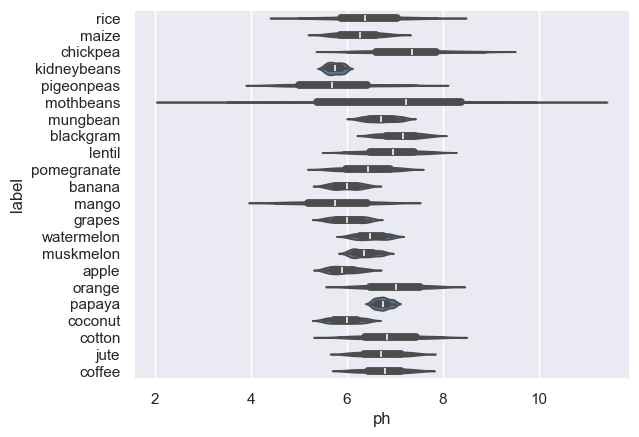

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6/7 [00:01<00:00,  3.42it/s]

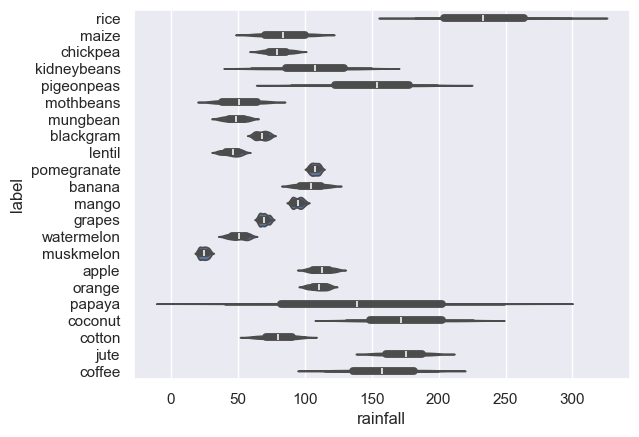

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.34it/s]


In [30]:
if class_flag:
    for elem in tqdm(num_features):
        sns.violinplot(x=elem, y=target, data=df)
        plt.show()

# Principal Component Analysis

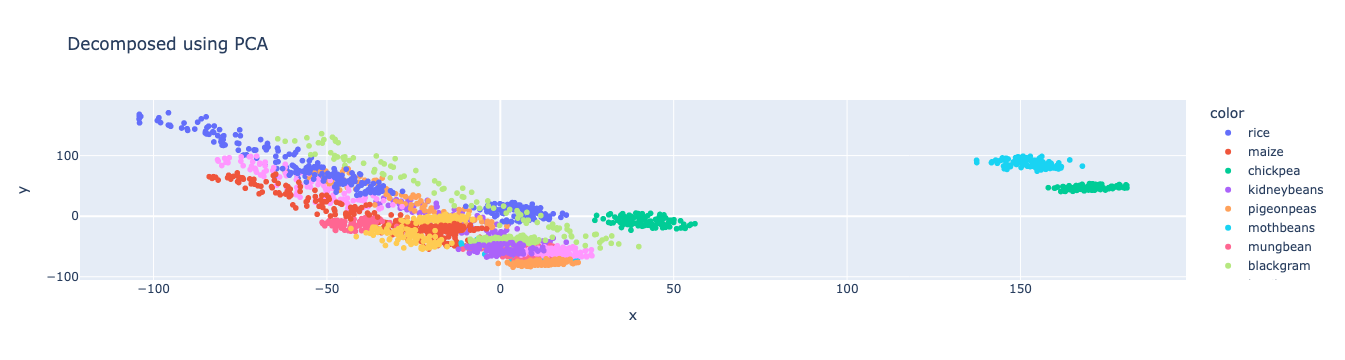

In [31]:
ll = num_features[:]
if target in ll:
    ll.remove(target)

pca=PCA(n_components=2)
df_pca=pca.fit_transform(df[ll])
df_pca=pd.DataFrame(df_pca)
fig = px.scatter(x=df_pca[0],y=df_pca[1],color=df[target],title="Decomposed using PCA")
fig.show()

# Feature engineering: create new features

#### Feature engineering depends drastically on the problem at hand (for example, sometimes binning must be applied to a continuous feature) so the code below is just an example of how to create a new feature.

In [32]:
def add_feature(row):
    if 'condition on row':
        return pd.to_numeric('new feature value depending on row', errors='coerce')
    else:
        return np.nan

# df['new_feature'] = df.apply(lambda row: add_feature(row), axis=1)

In [33]:
# If the new column depends on only one existing column:
# df['new_feature'] = np.where(condition on df['existing_feature'], value_onTrue, vale_on_False)
# Example: 
# df['good'] = np.where(df['NSM'] < 1000, True, False)
# df['good'] = np.where(df['NSM'] < 1000, 1, 0)

In [34]:
def add_feature(row):
    if 'condition1 on row':
        return 'value1'
    elif 'condition1 on row':
        return 'value2'
    else:
        return 'value3'

# df['new_feature'] = df.apply(add_feature, axis=1)

# Scaling and one-hot encoding

#### Keep in mind that there are different ways of scaling numerical features, each one with its own pros and cons, and it is not always necessary to scale a feature at all. See https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html for some examples of Scalers in scikit-learn. Here as an example the Standar Scaler is used.

#### Also keep in mind that there are different ways of encoding categorical features, e.g. one-hot encoding, label encoding, ordinal encoding, target encoding, etc. Each of them has its own pros and cons. Here as an example the one-hot encoding is used.

In [35]:
# df[num_features] = StandardScaler().fit_transform(df[num_features])
standard_scaler = StandardScaler().fit(df[num_features])
df[num_features] = standard_scaler.transform(df[num_features])

# Tests
epsilon = 1e-2
for elem in tqdm(num_features):
    assert abs(df[elem].mean()) < epsilon
    assert abs(df[elem].std() - 1) < epsilon

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2859.66it/s]


In [36]:
df.select_dtypes(exclude=["number", "datetime"]).head()

,label
0,rice
1,rice
2,rice
3,rice
4,rice


In [37]:
# One hot encoding of categorical features

cat_cols = df.select_dtypes(exclude=["number", "datetime"]).columns.to_list()
if target in cat_cols:
    cat_cols.remove(target)

ohe = pd.get_dummies(df, columns = cat_cols)

assert df is not ohe
del df
gc.collect()

# ohe

42806

In [38]:
# # Change columns names ([LightGBM] does not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in ohe.columns}
new_n_list = list(new_names.values())
# # [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
ohe = ohe.rename(columns=new_names)

# Models

In [39]:
if class_flag:
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(ohe[target])
    encoded_target = 'target_encoded' 
    ohe[encoded_target] = label_encoder.transform(ohe[target])    
    X = ohe.drop([target, encoded_target], axis=1)
    Y = ohe[[target, encoded_target]]
    # For classification problems only because of «stratify»
    x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.2, 
                                                        random_state=42)
else:
    X = ohe.drop([target], axis=1)
    Y = ohe[[target]]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state=42)
del ohe
gc.collect()

0

# First analysis of several candidate models

#### It is very important to choose the right scoring function. It is encoded in the variable `scoring_f`, see https://scikit-learn.org/stable/modules/model_evaluation.html for all available scoring functions in scikit-learn.

In [40]:
def models_analysis():
    class_models = []
    class_models.append(('CB_C', CatBoostClassifier(verbose=False)))
    class_models.append(('RF_C', RandomForestClassifier()))
    class_models.append(('LR', LogisticRegression()))
    class_models.append(('LDA', LinearDiscriminantAnalysis()))
    class_models.append(('KNN', KNeighborsClassifier()))
    class_models.append(('CART', DecisionTreeClassifier()))
    class_models.append(('NB', GaussianNB()))
    class_models.append(('SVM', SVC()))
    class_models.append(('LSVC', LinearSVC()))
    class_models.append(('GD_C', GradientBoostingClassifier()))
    class_models.append(('SGD_C', SGDClassifier()))
    class_models.append(('Ada_C', AdaBoostClassifier()))
    class_models.append(('LGBM_C', LGBMClassifier(verbose=-1)))
    class_models.append(('HGB_C', HistGradientBoostingClassifier()))
    class_models.append(('XGB_C', XGBClassifier()))

    regr_models = []
    regr_models.append(('Lin', LinearRegression()))
    regr_models.append(('Rid', Ridge(alpha = 0.5)))
    regr_models.append(('Las', Lasso(alpha = 0.5)))
    regr_models.append(('EN', ElasticNet(alpha=0.42)))
    regr_models.append(('GB_R', GradientBoostingRegressor()))
    regr_models.append(('SGD_R', SGDRegressor()))
    regr_models.append(('RF_R', RandomForestRegressor()))
    regr_models.append(('DT', DecisionTreeRegressor()))
    regr_models.append(('KN', KNeighborsRegressor()))
    regr_models.append(('LSVR', LinearSVR()))
    regr_models.append(('SVR', SVR())) 
    regr_models.append(('XGB_R', XGBRegressor()))
    regr_models.append(('Ada_R', AdaBoostRegressor()))
    regr_models.append(('HGB_R', HistGradientBoostingRegressor()))
    regr_models.append(('LGBM_R', LGBMRegressor(verbose=-1)))
    regr_models.append(('CB_R', CatBoostRegressor(verbose=False)))

    results = []
    names = []

    # For available scoring methods:
    # https://scikit-learn.org/stable/modules/model_evaluation.html
    if class_flag:
        models = class_models
        scoring_f = 'accuracy'
        # fold_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        fold_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,
                                          random_state=42)
    else:
        models = regr_models
        scoring_f = 'neg_mean_squared_error'
        fold_cv = RepeatedKFold(n_splits=10, n_repeats=5,
                                          random_state=42)
    
    for name, model in tqdm(models):
        if model.__class__.__name__ == 'XGBClassifier':
            scores = cross_val_score(model, x_train, y_train[encoded_target], cv=fold_cv,
                                     scoring=scoring_f, n_jobs=-1)
        else:
            scores = cross_val_score(model, x_train, y_train[target], cv=fold_cv,
                                     scoring=scoring_f, n_jobs=-1)
        results.append(scores)
        names.append(name)
        # print(f"Model: {name}, mean: {scores.mean()}, standard deviation: {scores.std()}.")
        print(f"Model: {model.__class__.__name__}, mean: {scores.mean()}, standard deviation: {scores.std()}.")
        # print(f"Model: {name}, full score: {scores}.")

    # Compare Algorithms
    plt.boxplot(results, tick_labels=names)
    plt.title('Algorithm Comparison')
    plt.show()

  7%|████████▏                                                                                                                 | 1/15 [05:21<1:15:07, 321.98s/it]

Model: CatBoostClassifier, mean: 0.992840909090909, standard deviation: 0.005544942226707205.


 13%|████████████████▌                                                                                                           | 2/15 [05:25<29:07, 134.43s/it]

Model: RandomForestClassifier, mean: 0.9948863636363636, standard deviation: 0.004580828266078723.


 27%|█████████████████████████████████▎                                                                                           | 4/15 [05:25<08:08, 44.39s/it]

Model: LogisticRegression, mean: 0.9704545454545453, standard deviation: 0.010720433104609767.
Model: LinearDiscriminantAnalysis, mean: 0.9638636363636364, standard deviation: 0.012944573514452848.


 40%|██████████████████████████████████████████████████                                                                           | 6/15 [05:25<02:49, 18.81s/it]

Model: KNeighborsClassifier, mean: 0.9681818181818181, standard deviation: 0.01368363020317305.
Model: DecisionTreeClassifier, mean: 0.9852272727272726, standard deviation: 0.009090909090909085.


 47%|██████████████████████████████████████████████████████████▎                                                                  | 7/15 [05:26<01:41, 12.70s/it]

Model: GaussianNB, mean: 0.9945454545454545, standard deviation: 0.005076888159929246.


 53%|██████████████████████████████████████████████████████████████████▋                                                          | 8/15 [05:26<01:01,  8.82s/it]

Model: SVC, mean: 0.9790909090909092, standard deviation: 0.011557438304628275.


 60%|███████████████████████████████████████████████████████████████████████████                                                  | 9/15 [05:26<00:36,  6.13s/it]

Model: LinearSVC, mean: 0.9613636363636363, standard deviation: 0.01405604190551474.


 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 10/15 [06:43<02:19, 27.90s/it]

Model: GradientBoostingClassifier, mean: 0.9877272727272727, standard deviation: 0.008222751143238876.


 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 11/15 [06:43<01:17, 19.49s/it]

Model: SGDClassifier, mean: 0.9071590909090907, standard deviation: 0.02557727111168548.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 12/15 [06:45<00:42, 14.15s/it]

Model: AdaBoostClassifier, mean: 0.23090909090909092, standard deviation: 0.07417556513306735.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 13/15 [07:53<01:00, 30.34s/it]

Model: LGBMClassifier, mean: 0.9907954545454545, standard deviation: 0.00841906656454157.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 14/15 [08:16<00:28, 28.09s/it]

Model: HistGradientBoostingClassifier, mean: 0.9917045454545453, standard deviation: 0.006931818181818178.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [08:18<00:00, 33.26s/it]

Model: XGBClassifier, mean: 0.9914772727272728, standard deviation: 0.006453304938409402.


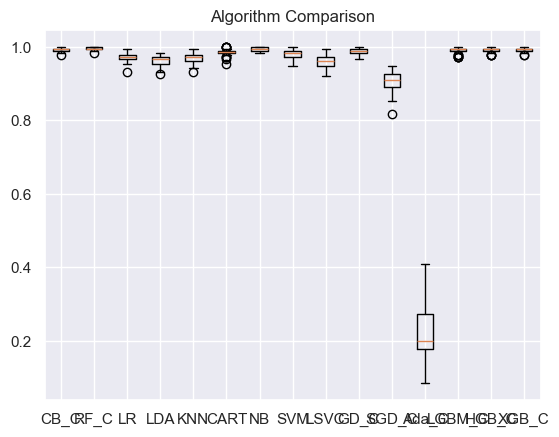

In [41]:
models_analysis()

# Training and evaluation

In [42]:
def train_model(clf):
    if clf.__class__.__name__ == 'XGBClassifier':
        new_target = encoded_target
    else:
        new_target = target
    clf.fit(x_train, y_train[new_target].values.ravel())
    return clf    

In [43]:
def model_eval(clf):
    if clf.__class__.__name__ == 'XGBClassifier' or (
        hasattr(clf, 'best_estimator_') and
        clf.best_estimator_.__class__.__name__ == 'XGBClassifier'):
        new_target = encoded_target
    else:
        new_target = target
    if class_flag:
        y_pred = clf.predict(x_test)
        y_pred_prob = clf.predict_proba(x_test)

        accuracy = metrics.accuracy_score(y_test[new_target], y_pred)

        print(clf.__class__.__name__)


        
        matrix = metrics.confusion_matrix(y_test[new_target], y_pred)
        report = metrics.classification_report(y_test[new_target], y_pred)

        if binary_flag:
            precision = metrics.precision_score(y_test[new_target], y_pred)
            recall = metrics.recall_score(y_test[new_target], y_pred)
            f1_score = metrics.f1_score(y_test[new_target], y_pred)
        else:
            precision = metrics.precision_score(
                y_test[new_target], y_pred, average=None
            )
            recall = metrics.recall_score(y_test[new_target], y_pred, average=None)
            f1_score = metrics.f1_score(y_test[new_target], y_pred, average=None)

        roc_auc = metrics.roc_auc_score(
            y_test[new_target], y_pred_prob, multi_class="ovr"
        )

        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("\n Confusion matrix \n", matrix)
        print("\n Classification report \n \n", report)

        print("\n Precision:", precision)
        print("\n Recall:", recall)
        print("\n F1 Score:", f1_score)

        print("\n Area Under the Receiver Operating Characteristic Curve:", roc_auc)

    else:
        y_pred = clf.predict(x_test)

        mae = metrics.mean_absolute_error(y_test[new_target], y_pred)
        mse = metrics.mean_squared_error(y_test[new_target], y_pred)
        # rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
        rmse = metrics.root_mean_squared_error(y_test[new_target], y_pred)
        mape = metrics.mean_absolute_percentage_error(y_test[new_target], y_pred)
        r2 = metrics.r2_score(y_test[new_target], y_pred)

        print("Mean Absolute Error:", mae)
        print("Mean Squared Error:", mse)
        print("Root Mean Squared Error:", rmse)
        print("Mean Absolute Percentage Error:", mape)
        print("Coefficient of determination R^2:", r2)

# Choosing the best model
According to the above analysis, choose the most suitable model for your use case.

#### Be careful that some classification models might not support the `predict_proba()` function, so the above code might need to be modified accordingly.

In [44]:
# For instance:

chosen_model = GaussianNB()
# chosen_model = LinearRegression()

In [45]:
model = train_model(chosen_model)
print("\n \n \033[1m Model Evaluation \033[0m \n")
model_eval(model)


 
  Model Evaluation  

GaussianNB
Accuracy: 99.55%

 Confusion matrix 
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 

# List of estimators which can be tuned with Grid Search or other optimization methods

In [46]:
class_models = []
class_models.append(('CB_C', CatBoostClassifier(verbose=False)))
class_models.append(('RF_C', RandomForestClassifier()))
class_models.append(('LR', LogisticRegression()))
class_models.append(('LDA', LinearDiscriminantAnalysis()))
class_models.append(('KNN', KNeighborsClassifier()))
class_models.append(('CART', DecisionTreeClassifier()))
class_models.append(('NB', GaussianNB()))
class_models.append(('SVM', SVC()))
class_models.append(('LSVC', LinearSVC()))
class_models.append(('GD_C', GradientBoostingClassifier()))
class_models.append(('SGD_C', SGDClassifier()))
class_models.append(('Ada_C', AdaBoostClassifier(algorithm='SAMME')))
class_models.append(('LGBM_C', LGBMClassifier(verbose=-1)))
class_models.append(('HGB_C', HistGradientBoostingClassifier()))
class_models.append(('XGB_C', XGBClassifier()))

for elem in class_models:
    print(elem[0], elem[1].get_params(), "\n\n\n")

CB_C {'verbose': False} 



RF_C {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 



LR {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



LDA {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001} 



KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': Non

# Hyperparameter tuning for Random Forest based models

#### For other type of models modify the below function `train_tune_model` using the estimators shown above. 

In [47]:
def train_tune_model(ml_model):
    if ml_model.__class__.__name__ == 'XGBClassifier':
        new_target = encoded_target
    else:
        new_target = target
# # Only for Random Forest based models
    parameters = {'n_estimators':[50, 75, 100, 150, 200, 250, 300, 350],
                  'max_depth':[10, 15, 20, 25, 30, 35, 40], 
    # # only for Gradient Boosting based models 
                  #'learning_rate':[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
                 }    
    
    # clf = GridSearchCV(estimator=ml_model, param_grid=parameters, n_jobs=-1)
    clf = RandomizedSearchCV(estimator=ml_model, param_distributions=parameters, cv=5, n_jobs=-1)
    
    clf.fit(x_train, y_train[new_target].values.ravel())
    clf.score(x_test, y_test[new_target])

    features_importance=pd.DataFrame(sorted(list(zip(clf.best_estimator_.feature_importances_,
                                     x_train.columns)), reverse=True))
    print(features_importance)
    # features_importance.to_csv('features_importance.csv', header=False, index=False)

    print(clf.best_params_)
    print(clf.best_score_)
        
    return clf

### Here as an example XGBoost is used.

In [48]:
model_rf_based = train_tune_model(XGBClassifier())
# model_rf_based = train_tune_model(XGBRegressor())
model_eval(model_rf_based)

          0            1
0  0.197070            K
1  0.183589            P
2  0.164881     rainfall
3  0.163006     humidity
4  0.152433            N
5  0.082539  temperature
6  0.056481           ph
{'n_estimators': 75, 'max_depth': 25}
0.9897727272727274
RandomizedSearchCV
Accuracy: 99.32%

 Confusion matrix 
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0 

# Save the model as a serialized file

In [49]:
def save_model(clf):
    # basepath: str = os.path.join('../models', f"{datetime.datetime.now(tz=datetime.timezone.utc).strftime('%Y%m%d_%H%M%S')}"
    #                                    f"_model")
    basepath: str = '../models'
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    with open(os.path.join(basepath, "best_model.joblib"), mode="wb") as f:
        joblib.dump(clf, f)
    with open(os.path.join(basepath, "num_features.pkl"), mode="wb") as f:
        pickle.dump(num_features, f)
    with open(os.path.join(basepath, "standard_scaler.pkl"), mode="wb") as f:
        pickle.dump(standard_scaler, f)
    if clf.__class__.__name__ == 'XGBClassifier':
        with open(os.path.join(basepath, "label_encoder.pkl"), mode="wb") as f:
            pickle.dump(label_encoder, f)

In [50]:
save_model(model)

# Prediction
Load the model and use it for predictions.

Be careful that if some scaling or encodings of categorical features are used, they must be applied to the input before sending it to the model.

In [51]:
with open("../models/best_model.joblib", mode="rb") as f:
            model = joblib.load(f)
model

,priors,None
,var_smoothing,1e-09


### If the chosen model is `XGBClassifier` then the predicted class must be decoded using the function `label_encoder.inverse_transform`, e.g. `label_encoder.inverse_transform([0, 0, 1, 2])`.